# Lab 5:  Regularization
#### [Penn State Astroinformatics Summer School 2022](https://sites.psu.edu/astrostatistics/astroinfo-su22/)
#### [Rodrigo Luger](https://luger.dev/)

## Install

In [1]:
#  !pip install scipy pandas ipywidgets celerite > /dev/null  # If not running on summer school servers, then you may need to uncomment to install this (and potentially other) packages

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## ``Problem 1`` Interactive polynomial fitting

In this problem, we'll interactively explore the idea of regularization in the context of a very simple model: fitting a polynomial to some data.

### Get the data

We'll call the function ``get_problem1_data`` in the ``regularization`` module (located in the same directory as this notebook) to get the dataset we'll need. Whenever importing a function from that module, it's a good idea to print its docstring to see what it does.

In [3]:
from regularization import get_problem1_data
print(get_problem1_data.__doc__)

Generate the dataset for Problem 1.

    Returns:
        pandas.DataFrame: A data frame containing the data vectors ``x`` and
            ``y`` as well as boolean masks ``train_idx`` and ``test_idx``
            specifying the indices of the training set points and test set
            points, respectively.
    


In [4]:
data = get_problem1_data()

As advertised, we have our data arrays ``x`` and ``y`` and boolean masks telling us whether each data point is in the *training* set or the *test* set:

In [5]:
data.head()

,x,y,train_idx,test_idx
0,-0.500000,-0.475257,True,False
1,-0.489899,-0.478284,False,True
2,-0.479798,-0.461250,False,True
3,-0.469697,-0.442229,False,True
4,-0.459596,-0.450726,False,True


### Fitting a polynomial to data

The ``regularization`` module provides an interactive widget to visualize this dataset. Let's import it:

In [6]:
from regularization import interact
print(interact.__doc__)

Interactive widget for visualizing the effects of regularization.

    Args:
        data (pandas.DataFrame): The data frame for Problem 1; see
            ``get_problem1_data``.
        plot_test_set (bool, optional): Whether to show the terst set.
            Defaults to False.
        regularize (str, optional): Whether or not to apply regularization.
            Options are "none", "l1", and "l2". Defaults to "none".
    


The following cell plots the training set (black points), which we fit with a polynomial (blue curve). The slider at the bottom of the plot controls the highest order of the polynomial, ranging from 0 to 50. 

Play around with the slider to get a sense of how the order affects the quality of the fit. The value of the loss (computed using the reduced chi-squared metric) for the training set is shown at the top right. Below that, we show the (log of the absolute value of the) coefficients of the fit.

**``Problem 1A``** What effect does increasing the order of the fit have on the training loss? Which value of the order minimizes the loss? Does that "look" like a good fit to you? Why or why not?

In [7]:
interact(data)

Output()

### Regularizing the fit: limiting the order of the fit

You may have noticed that increasing the order of the fit leads to extreme oscillations in our model. This is *almost always* a bad thing, as it's a pretty good sign that the model is **overfitting** the data. We can see overfitting in action by plotting the remainder of our dataset (the test points), which we held out in the previous exercise.

Executing the following cell will plot the test set (in orange) and show the value of the loss computed for the test set. Since the test points are unknown to the model (the model is trained exclusively on the training points), the value of the test loss is a good metric to gauge overfitting.

**``Problem 1B``** What happens to the value of the test loss as the order of the polynomial is increased? Is the behavior monotonic? What is the polynomial order that minimizes the test loss? Is it the same value that minimizes the training loss? Why?

**``Problem 1C``** In this example, we can prevent overfitting by keeping the order of polynomial fit small. But if the order is *too* small, we'll experience the opposite effect of **underfitting**. Is there a particular order that leads to a "good-looking" model that balances overfitting and underfitting?

In [8]:
interact(data, plot_test_set=True)

Output()

### Regularizing the fit: L2

To prevent overfitting, there are other things we can do besides limiting the order of our model (or, equivalently, the number of regressors). The next cell applies L2 regularization to our linear fit, so there's an extra slider at the bottom controlling the log of the strength of the regularization term (which we call $\lambda$).

**``Problem 1D``** Play around with different values of the polynomial order and ``log_lambda``, and comment on the values that minimize the training loss and test loss. As the L2 regularization strength is increased, what happens to the value of the model weights? Discuss.

In [9]:
interact(data, plot_test_set=True, regularize="l2")

Output()

### Regularizing the fit: L1

There are many other ways to perform regularization. A common alternative to L2 is the L1 penalty, which is also controlled by a parameter called $\lambda$.

**``Problem 1E``** Play around with different values of the polynomial order and ``log_lambda``, and comment on the values that minimize the training loss and test loss. As the L1 regularization strength is increased, what happens to the value of the model weights? How is this different from L2 regularization? Discuss.

In [10]:
interact(data, plot_test_set=True, regularize="l1")

Output()

## ``Problem 2`` Cross-validation

In the previous problem, we tried to gauge the "correct" amount of regularization to apply by looking at the performance of the model on the test set. We can formalize this approach with a tecnhique known as **cross validation**, in which we find the value of the regularization parameter that minimizes the loss on held out data.

Let's import two more functions for this problem:

In [11]:
from regularization import poly_design_matrix
print(poly_design_matrix.__doc__)

A design matrix constructed out of the Legendre polynomial basis.

    Args:
        x (ndarray): The independent coordinate vector, length ``N``.
        ncol (int): The number of columns ``M`` in the design matrix.
            Note that this corresponds to a polynomial fit with highest
            order equal to ``M - 1``.

    Returns:
        ndarray: The design matrix for the linear problem, shape ``(N, M)``.
    


In [12]:
from regularization import get_cv_loss
print(get_cv_loss.__doc__)

Returns the cross-validation loss in both the training set and the test set.

    Args:
        data (pandas.DataFrame): A dataframe containing the dataset,
            ``x`` and ``y``, and the training/test set boolean index masks,
            ``train_idx`` and ``test_idx``.
        A (ndarray): The design matrix for the linear problem, shape ``(N, M)``.
        regularize (str, optional): Whether or not to apply regularization. Options are
            "none", "l1", and "l2". Defaults to "none".
        log_lam (float or ndarray, optional): The log of the regularization
            strength parameter, ``lambda``. This may either be a scalar or
            a vector of length ``N``. Defaults to 5.0.

    Returns:
        tuple: Two floats corresponding to the loss in the training set and
            the test set, respectively.

    


We'll start by doing some **very simple** cross-validation to find the ideal polynomial order (in the absence of L2 or L1 regularization). The idea is to iterate over all 50 values of the polynomial order and for each one compute the corresponding design matrix ``A`` and pass that to ``get_cv_loss`` to compute the corresponding cross-validation loss. For simplicity, we'll use the same division between training and test data as we did above. (If we wanted to make our model more robust, we could compute the cross-validation losses for many different partitions between training and test data, and draw conclusions from the average.)

**``Problem 2A``** Inspect the code below and execute the cell. Comment on the behavior of the training loss and test loss as the polynomial order is increased. What's the best value of the polynomial order? Is this consistent with what you found in Problem 1C?

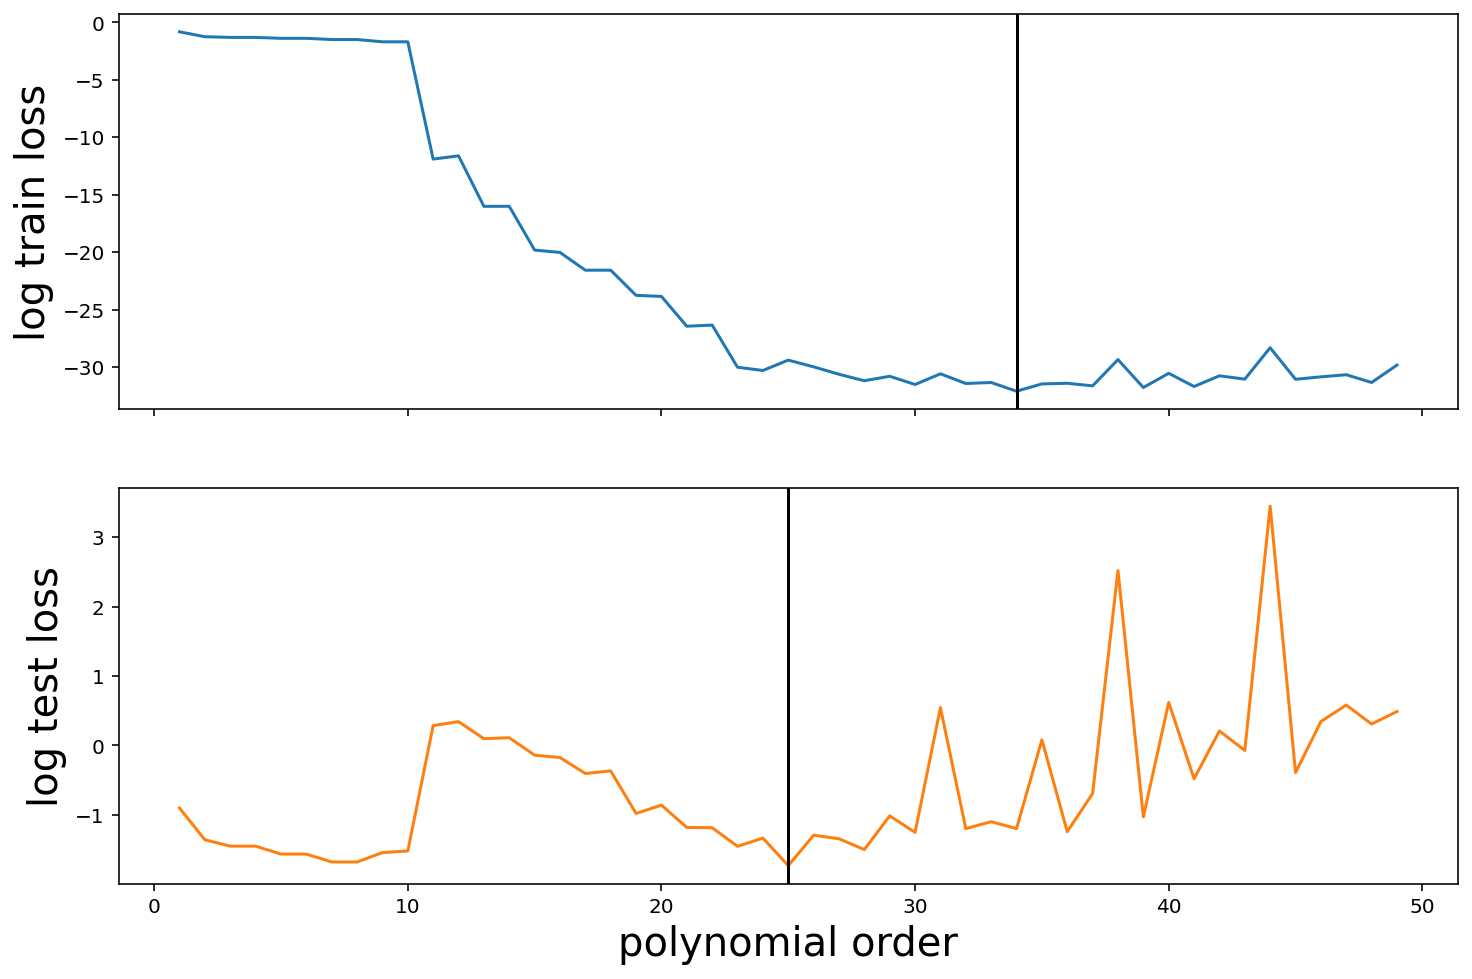

In [13]:
# Compute the train and test loss
poly_order = np.arange(1, 50)
train_loss = np.zeros_like(poly_order, dtype=float)
test_loss = np.zeros_like(poly_order, dtype=float)
for n in range(len(poly_order)):
    A = poly_design_matrix(data["x"], poly_order[n])
    train_loss[n], test_loss[n] = get_cv_loss(data, A, regularize="none")

# Find index of best loss for the train & test sets
best_train_idx = np.argmin(train_loss)
best_test_idx = np.argmin(test_loss)

# Plot
fig, ax = plt.subplots(2, figsize=(12, 8), sharex=True)
ax[0].plot(poly_order, np.log10(train_loss))
ax[1].plot(poly_order, np.log10(test_loss), "C1")
ax[0].axvline(poly_order[best_train_idx], color="k")
ax[1].axvline(poly_order[best_test_idx], color="k")
ax[1].set_xlabel("polynomial order", fontsize=20)
ax[0].set_ylabel("log train loss", fontsize=20)
ax[1].set_ylabel("log test loss", fontsize=20);

**``Problem 2B``** Repeat the cross-validation exercise for the L2 loss. Fix the polynomial design matrix order at ``50`` and iterate over different values of ``log_lam`` spanning the range ``(-18, 3)``, then plot the training loss and test loss as a function of ``log_lam``. Comment on the overall shape of the test loss. What is the optimal value of the regularization strength? What is the corresponding test loss?

**``Problem 2C``** Repeat Problem 2B, but for the L1 loss.

## ``Problem 3`` Searching for an exoplanet transit

Below we will analyze a light curve of a star collected with a fictitious telescope. We suspect that there is an exoplanet transit hiding somewhere in the dataset, but unfortunately the light curve is dominated by instrument systematics.

Your task is to find the transit and report the approximate time of transit and transit depth (in ppm).

Let's import the relevant function:

In [14]:
from regularization import get_problem3_data
print(get_problem3_data.__doc__)

Generate the dataset for Problem 3.

    Returns:
        pandas.DataFrame: A data frame containing the data vectors ``x`` and
            ``y`` as well as the housekeeping variable vectors ``temperature``,
            ``cloudiness``, ``psf_stability``, ``humidity``, and ``air_pressure``.
    


Below we plot the flux as a function of time:

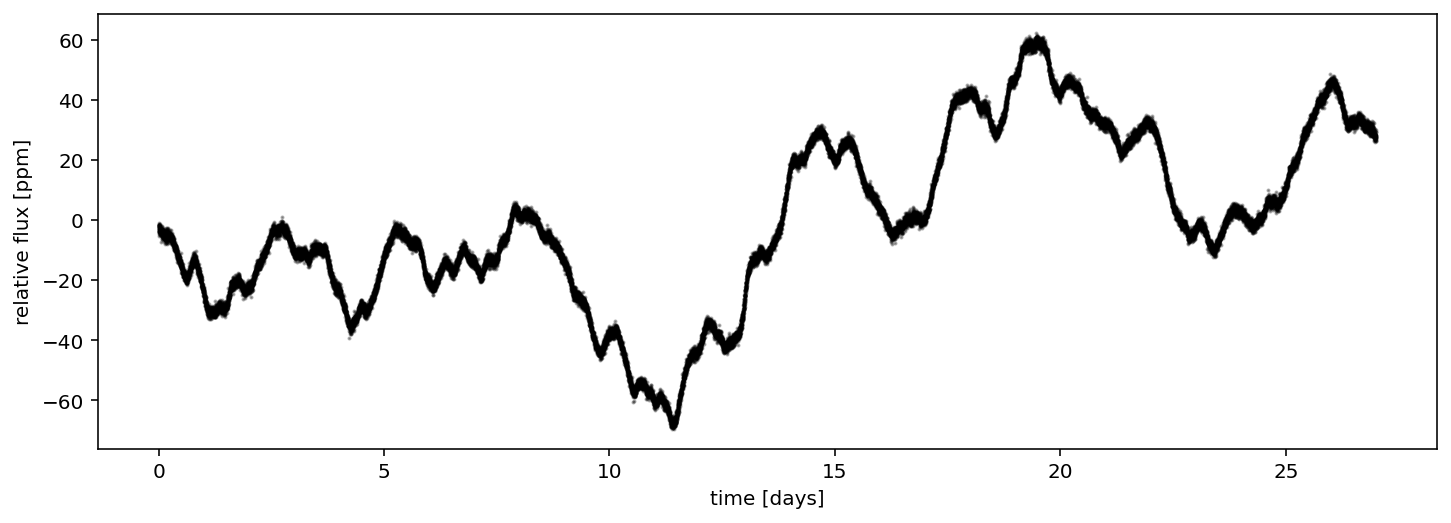

In [15]:
# Load the data
data = get_problem3_data()

# Plot it
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(data["x"], data["y"], 'k.', alpha=0.3, ms=2)
ax.set_ylabel("relative flux [ppm]")
ax.set_xlabel("time [days]");

There are lots of features that look transit-like! Normally we'd be at a loss, but fortunately we have access to a few telescope housekeeping variables that we suspect correlate with the systematics component of the light curve. Let's take a look at the data frame:

In [16]:
data.head()

,x,y,temperature,cloudiness,psf_stability,humidity,air_pressure
0,0.000000,-3.733752,4.254513,-4.019605,-1.160100,-6.360637,-1.496569
1,0.000694,-1.658680,4.247355,-4.014178,-1.162467,-6.359643,-1.497345
2,0.001389,-1.579171,4.240592,-4.009298,-1.164907,-6.358750,-1.497830
3,0.002083,-2.322379,4.233681,-4.004617,-1.167572,-6.357873,-1.498096
4,0.002778,-1.530432,4.226457,-3.999685,-1.170057,-6.356870,-1.498100


We can construct a design matrix out of these housekeeping variables as follows:

In [17]:
# Construct the design matrix
A = np.hstack(
    (
        np.array(data["temperature"]).reshape(-1, 1),
        np.array(data["cloudiness"]).reshape(-1, 1),
        np.array(data["psf_stability"]).reshape(-1, 1),
        np.array(data["humidity"]).reshape(-1, 1),
        np.array(data["air_pressure"]).reshape(-1, 1),
    )
)

This is analogous to the polynomial design matrix we used in the previous problems, but this time our regressors correspond to actual physically-motivated quantities (instead of just a standard basis of polynomials).

Here's what each of the components looks like:

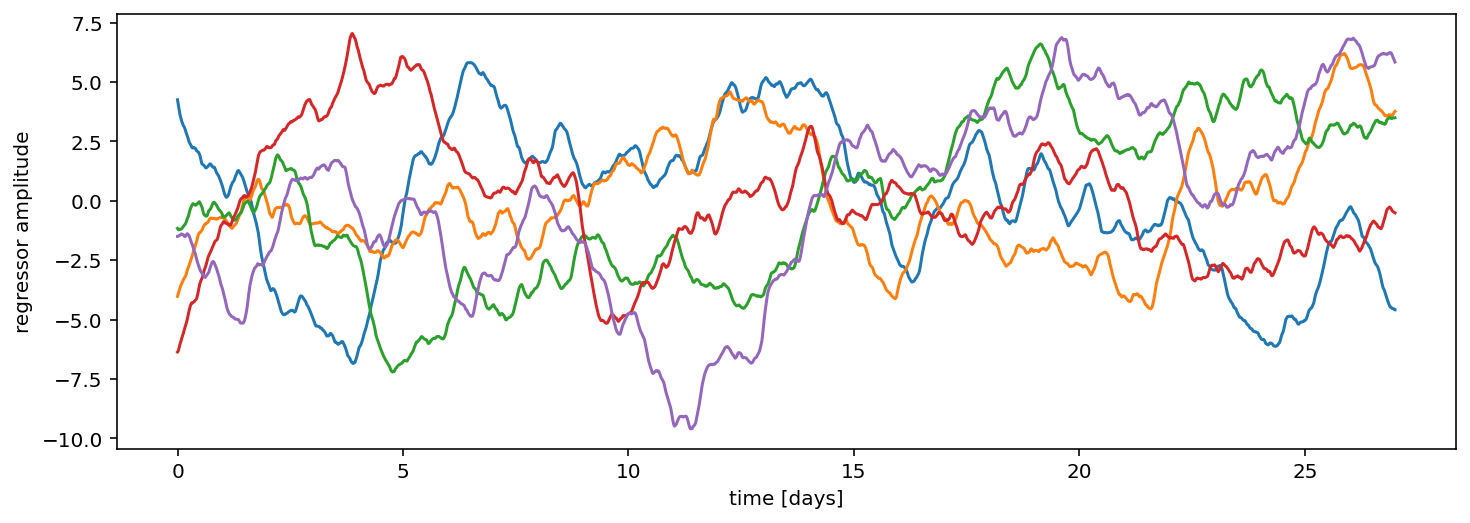

In [18]:
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(data["x"], A)
ax.set_ylabel("regressor amplitude")
ax.set_xlabel("time [days]");

In the following problem, we'll do a simple linear regression using the following function:

In [19]:
from regularization import lstsq
print(lstsq.__doc__)

Unregularized least squares solver.

    Args:
        A (ndarray): The design matrix for the linear problem, shape ``(N, M)``.
        y (ndarray): The data vector, length ``N``.

    Returns:
        ndarray: The vector of coefficients ``w`` that minimizes the chi squared
            loss.
    


**``Problem 3A``** Perform a simple linear regression using this design matrix to construct your best fit model of the light curve systematics. Then have a look at the residuals: can you see the transit? What is the approximate time of transit (in days) and depth (in ppm)? Why did we not need to explicitly add regularization in this case?

## ``Problem 4`` Searching for an exoplanet transit: many regressors

Now suppose we have a different telescope with lots of systematics, but this time we have **hundreds** of housekeeping variables that could correlate with our systematics. As in the previous problem, we think there's a transit hiding somewhere in the light curve. Below we will de-trend the dataset using all of the housekeeping variables and attempt to find the transit.

In [20]:
from regularization import get_problem4_data
print(get_problem4_data.__doc__)

Generate the dataset for Problem 4.

    Returns:
        pandas.DataFrame: A data frame containing the data vectors ``x`` and
            ``y`` as well as 500 housekeeping vectors named ``A000`` through
            ``A499``.
    


Let's load the dataset and inspect it:

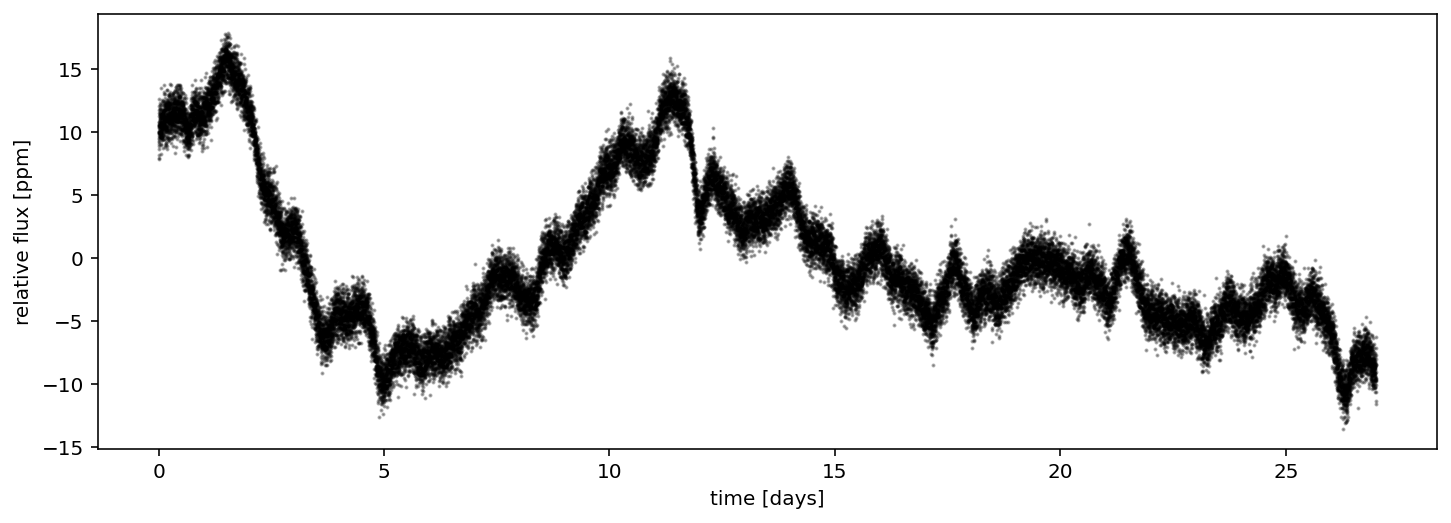

In [21]:
# Load the data
data = get_problem4_data()

# Get the design matrix
A = np.hstack([np.array(data["A%03d" % n]).reshape(-1, 1) for n in range(500)])

# Plot it
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(data["x"], data["y"], 'k.', alpha=0.3, ms=2)
ax.set_ylabel("relative flux [ppm]")
ax.set_xlabel("time [days]");

**``Problem 4A``** Perform a simple linear least-squares fit with no regularization to de-trend the light curve, and inspect the residuals. Do you see the transit? What happened?

For the next problem, we'll use the following least squares solver with built-in L2 regularization:

In [22]:
from regularization import L2
print(L2.__doc__)

L2 regularized least squares solver.

    Args:
        A (ndarray): The design matrix for the linear problem, shape ``(N, M)``.
        y (ndarray): The data vector, length ``N``.
        log_lam (float or ndarray, optional): The log of the regularization
            strength parameter, ``lambda``. This may either be a scalar or
            a vector of length ``N``. Defaults to 5.0.

    Returns:
        ndarray: The vector of coefficients ``w`` that minimizes the L2 norm
            for the linear problem.
    


**``Problem 4B``** Now do the same thing as in Problem 4A, but add an L2 regularization term. You'll probably have to experiment with different values of the regularization strength (hint: try a value of ``log_lam`` between ``3.0`` and ``6.0``). Can you find the transit now? What happens if the regularization is too strong? Too weak?

**``Problem 4C [Bonus]``** Repeat Problem 4B, but this time first perform cross-validation to find the optimal value of the L2 regularization strength. Since we're specifically interested in recovering the transit, we should choose our cross-validation test and training sets to gauge overfitting on timescales comparable to the transit duration, which is about 0.5 days or ``750`` points. Therefore our test set should consist of a chunk of ``750`` consecutive points. There are many different such sets we can construct from our light curve, so perform this cross-validation several (10-30) times and compute the median of the optimal regularization strength over all sets. How does this value compare to the one you chose in the previous problem? De-trend the dataset using this value; are you able to recover the transit well?

## ``Problem 5`` Searching for an exoplanet transit: joint modeling

One of the classic problems with de-trending is that quite often we throw the baby out with the bathwater. When removing the systematics like we did above, we almost always end up removing a bit of the signal we actually care about, *even if we regularize properly*.

One way around this is to **simultaneously** fit the systematics model and the transit model.

Suppose for simplicity that we know the time of the transit and the shape of the transit exactly, but we do not know the depth. Here's the functional form of the transit model:

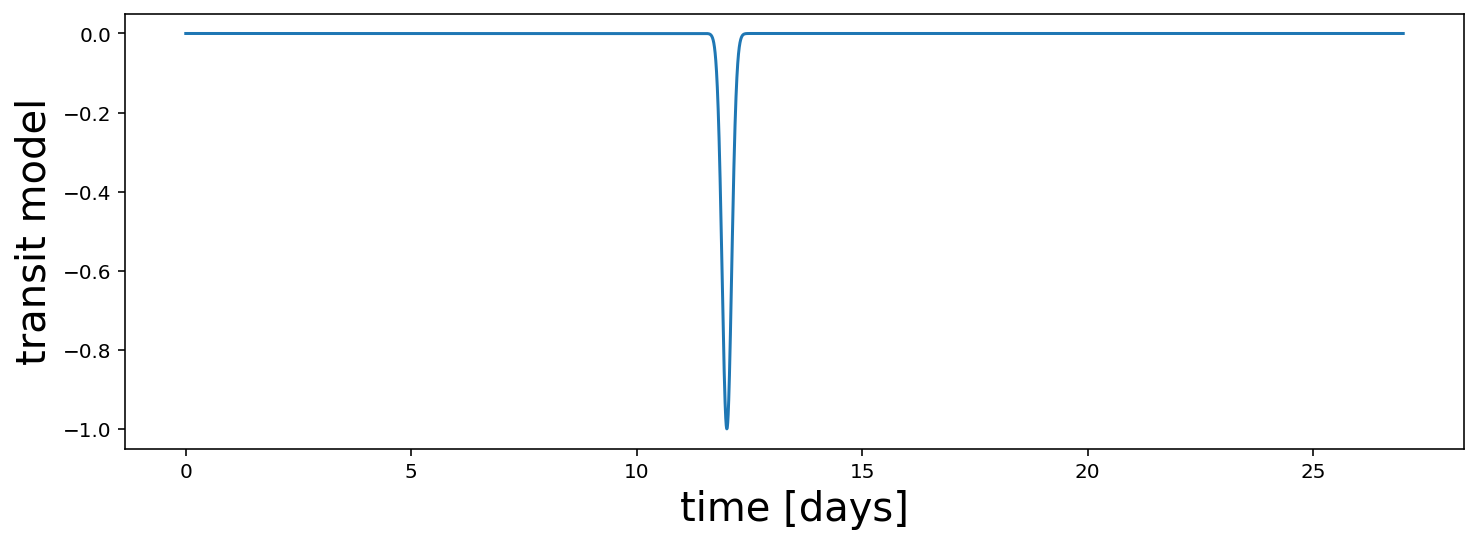

In [23]:
t0 = 12.0
sig_t = 0.15
transit_model = -np.exp(-(np.array(data["x"]) - t0) ** 2 / sig_t ** 2)
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(data["x"], transit_model)
ax.set_xlabel("time [days]", fontsize=20)
ax.set_ylabel("transit model", fontsize=20);

**``Problem 5A``** Append this transit model to the last column of your design matrix, ``A``. Then perform L2-regularized least squares using the same regularization strength you determined above. Note that you want to make sure to not apply the regularization to the transit model to avoid biasing the transit depth low. If you inspect the docstring of the ``L2`` function (see above), you'll notice that it accepts a vector for ``log_lam``. So for this problem, you should use

```
log_lam = np.append(best_log_lam * np.ones(500), -np.inf)
```

where `best_log_lam` is the optimal value you found above, and the last term in the vector corresponds to zero regularization strength (i.e., minus infinity in log space). After you perform the fit, plot the data minus the systematics component of the model. How do your results compare to those of the previous problem? How does the transit depth compare?